In [791]:
%load_ext autoreload
%autoreload 2
from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.potential import (
    LJ,
    DE,
)
from ff_energy.ffe.ff import FF
from ff_energy.ffe.constants import FFEPATH
from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit
from ff_energy.plotting.plotting import set_style
from ff_energy.plotting.fit_results import residuals_plot, residuals_from_keys
from ff_energy.logs.logging import hide_logs
from ff_energy.ffe.potential import LJ, LJ_bound, DE

hide_logs()
import scienceplots
set_style(no_latex=True)

# sns.set_style()
# plt.style.use(["science", "no-latex"])

from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json
from ff_energy.ffe.structure import atom_key_pairs

# structure_data = {
#     "dcm": "",
#     "water_cluster": PKL_PATH / "20230823_water_clusters.pkl.pkl",
# }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
"hello"

In [2]:
WORKINGDATA = FFEPATH / "notebooks" / "working" / "data"
DCMDATA = list(WORKINGDATA.glob("dcm*"))
dcmdimerdata = {_.name: pd.DataFrame([ [y if i == 0 else float(y) for i,y in enumerate(x.split())] for x in open(_).readlines()]) for _ in DCMDATA}
# dcmdimerdata

In [792]:
pol = dcmdimerdata["dcmdimerscan_pol.txt"][1]
emon = dcmdimerdata["dcmdimerscan_emon.txt"][1]
ecol = dcmdimerdata["dcmdimerscan_ci.txt"][1]
etot = dcmdimerdata["dcmdimerscan_etot.txt"][1]
key = "r" + dcmdimerdata["dcmdimerscan_etot.txt"][0] + ".xyz"
mone = dcmdimerdata["dcmdimerscan_emon.txt"][[1,2]].sum(axis=1)
intE = (etot - mone) * 627.503

# intE
# mone.sum(axis=1)

In [793]:
df = pd.DataFrame({
    "pol": pol,
    "ecol": ecol,
    "etot": etot,
    "mone": mone,
    "intE": intE,
    "KEY": key
                  },
)
df.index = list(df["KEY"])
df = df.sort_index()

In [794]:
df

,pol,ecol,etot,mone,intE,KEY
r3.1.xyz,-0.725542,-14.543985,-1918.733283,-1918.743239,6.247387,r3.1.xyz
r3.2.xyz,-0.618177,-11.353579,-1918.738070,-1918.743239,3.243803,r3.2.xyz
r3.3.xyz,-0.522443,-8.916788,-1918.741405,-1918.743239,1.150776,r3.3.xyz
r3.4.xyz,-0.439705,-7.058588,-1918.743664,-1918.743239,-0.266714,r3.4.xyz
r3.5.xyz,-0.368734,-5.641959,-1918.745133,-1918.743239,-1.188596,r3.5.xyz
r3.6.xyz,-0.309059,-4.560448,-1918.746032,-1918.743239,-1.752808,r3.6.xyz
r3.7.xyz,-0.257740,-3.732007,-1918.746528,-1918.743239,-2.063671,r3.7.xyz
r3.8.xyz,-0.216844,-3.093928,-1918.746744,-1918.743239,-2.199488,r3.8.xyz
r3.9.xyz,-0.183048,-2.598683,-1918.746773,-1918.743239,-2.217770,r3.9.xyz
r3.xyz,-0.840919,-18.709878,-1918.726558,-1918.743239,10.467114,r3.xyz


In [796]:
# _ = "dcmdimerscan_pbe0dz_mdcm.pkl"
# mmmdcm_data = next(read_from_pickle(_))
# mmmdcm_data = dcm_data.data.dropna()

In [797]:
_ = "dcmdimerscan_pbe0dz_pc.pkl"
dcm_data = next(read_from_pickle(_))
dcm_data = dcm_data.data.dropna()

In [798]:
test = dcm_data
dcm_data["INT"] = (dcm_data["C_ENERGY"] - dcm_data["M_ENERGY"]) * 627.503
dcm_data.index = list(dcm_data["KEY"])
dcm_data = dcm_data.sort_index()
# dcm_data["mikeIntE"] = df["intE"]
dcm_data
# df

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,P_ENERGY,P_intE,intE,C_ENERGY_kcalmol,INT
r3.1.xyz,19.15613,-0.84157,19.22300,r3.1.xyz,-1918.743238,2.0,-1918.744355,-1918.744355,6.238247,-0.700720,-1.204018e+06,-0.700720
r3.2.xyz,11.19794,-0.77328,10.28236,r3.2.xyz,-1918.743238,2.0,-1918.744567,-1918.744567,3.244100,-0.834039,-1.204018e+06,-0.834039
r3.3.xyz,7.22620,-0.71148,5.04008,r3.3.xyz,-1918.743238,2.0,-1918.743684,-1918.743684,1.143318,-0.279841,-1.204017e+06,-0.279841
r3.4.xyz,5.51765,-0.65623,1.99860,r3.4.xyz,-1918.743238,2.0,-1918.743549,-1918.743549,-0.268664,-0.195078,-1.204017e+06,-0.195078
r3.5.xyz,5.01956,-0.60614,0.23506,r3.5.xyz,-1918.743238,2.0,-1918.743666,-1918.743666,-1.190637,-0.268665,-1.204017e+06,-0.268665
r3.6.xyz,4.87844,-0.56134,-0.75695,r3.6.xyz,-1918.743238,2.0,-1918.745288,-1918.745288,-1.754321,-1.286086,-1.204018e+06,-1.286086
r3.7.xyz,4.94221,-0.52025,-1.29823,r3.7.xyz,-1918.743238,2.0,-1918.743656,-1918.743656,-2.065517,-0.262485,-1.204017e+06,-0.262485
r3.8.xyz,4.91573,-0.48333,-1.55766,r3.8.xyz,-1918.743238,2.0,-1918.745136,-1918.745136,-2.199199,-1.190643,-1.204018e+06,-1.190643
r3.9.xyz,4.96954,-0.44967,-1.65381,r3.9.xyz,-1918.743238,2.0,-1918.743445,-1918.743445,-2.220741,-0.129573,-1.204017e+06,-0.129573
r3.xyz,34.44041,-0.91863,34.89404,r3.xyz,-1918.743238,2.0,-1918.745121,-1918.745121,10.473201,-1.181325,-1.204018e+06,-1.181325


In [800]:
# dcm_data.join(df, lsuffix="mike", on="KEY")


In [801]:
df.describe()

,pol,ecol,etot,mone,intE
count,51.000000,51.000000,51.000000,5.100000e+01,51.000000
mean,-0.117792,-2.014498,-1918.743758,-1.918743e+03,-0.326025
std,0.192630,3.791974,0.003244,7.170819e-12,2.035511
min,-0.840919,-18.709878,-1918.746773,-1.918743e+03,-2.217770
25%,-0.103702,-1.555194,-1918.745126,-1.918743e+03,-1.184249
50%,-0.027810,-0.471261,-1918.743919,-1.918743e+03,-0.427029
75%,-0.017392,-0.214381,-1918.743559,-1.918743e+03,-0.200870
max,-0.015064,-0.117433,-1918.726558,-1.918743e+03,10.467114


In [14]:
p = read_from_pickle("structures/dcmdimerscan.pkl")
structures, pdbs = next(p)

#  DEBUG

In [18]:
s = structures[6]
s.set_2body()

print()

for i, d in enumerate(s.distances_pairs):
    # print(s.name)
    print(i, atom_key_pairs[i], d)

C C
.
C CG331
C CL
.
.
C H
.
.
C HGA3
C HGP1
C HT
C OG311
C OT
CG331 CG331
CG331 CL
CG331 H
CG331 HGA3
CG331 HGP1
CG331 HT
CG331 OG311
CG331 OT
CL CL
.
CL H
.
.
CL HGA3
CL HGP1
CL HT
CL OG311
CL OT
H H
.
H HGA3
H HGP1
H HT
H OG311
H OT
HGA3 HGA3
HGA3 HGP1
HGA3 HT
HGA3 OG311
HGA3 OT
HGP1 HGP1
HGP1 HT
HGP1 OG311
HGP1 OT
HT HT
HT OG311
HT OT
OG311 OG311
OG311 OT
OT OT

0 ('C', 'C') {(1, 2): [array([[3.10044207]])]}
1 ('C', 'CG331') {}
2 ('C', 'CL') {(2, 1): [array([[3.19336954, 3.12096043]]), array([[4.84067382, 3.06938903]])]}
3 ('C', 'CLA') {}
4 ('C', 'H') {(1, 2): [array([[3.13456887, 2.69231276]]), array([[4.18681609, 2.74418185]])]}
5 ('C', 'HGA3') {}
6 ('C', 'HGP1') {}
7 ('C', 'HT') {}
8 ('C', 'OG311') {}
9 ('C', 'OT') {}
10 ('C', 'POT') {}
11 ('CG331', 'CG331') {}
12 ('CG331', 'CL') {}
13 ('CG331', 'CLA') {}
14 ('CG331', 'H') {}
15 ('CG331', 'HGA3') {}
16 ('CG331', 'HGP1') {}
17 ('CG331', 'HT') {}
18 ('CG331', 'OG311') {}
19 ('CG331', 'OT') {}
20 ('CG331', 'POT') {}
21 ('CL', 'CL')

In [438]:
# s.distances_pairs

In [20]:
def strippdbext(x):
    return x.strip(".pdb")


for _ in structures:
    _.set_2body()

dists = {
    strippdbext(str(Path(_.name))):
        _.distances for _ in structures
}
# print(dists.keys())
# print(dcm_data.KEY)

C C
.
C CG331
C CL
.
.
C H
.
.
C HGA3
C HGP1
C HT
C OG311
C OT
CG331 CG331
CG331 CL
CG331 H
CG331 HGA3
CG331 HGP1
CG331 HT
CG331 OG311
CG331 OT
CL CL
.
CL H
.
.
CL HGA3
CL HGP1
CL HT
CL OG311
CL OT
H H
.
H HGA3
H HGP1
H HT
H OG311
H OT
HGA3 HGA3
HGA3 HGP1
HGA3 HT
HGA3 OG311
HGA3 OT
HGP1 HGP1
HGP1 HT
HGP1 OG311
HGP1 OT
HT HT
HT OG311
HT OT
OG311 OG311
OG311 OT
OT OT
C C
.
C CG331
C CL
.
.
C H
.
.
C HGA3
C HGP1
C HT
C OG311
C OT
CG331 CG331
CG331 CL
CG331 H
CG331 HGA3
CG331 HGP1
CG331 HT
CG331 OG311
CG331 OT
CL CL
.
CL H
.
.
CL HGA3
CL HGP1
CL HT
CL OG311
CL OT
H H
.
H HGA3
H HGP1
H HT
H OG311
H OT
HGA3 HGA3
HGA3 HGP1
HGA3 HT
HGA3 OG311
HGA3 OT
HGP1 HGP1
HGP1 HT
HGP1 OG311
HGP1 OT
HT HT
HT OG311
HT OT
OG311 OG311
OG311 OT
OT OT
C C
.
C CG331
C CL
.
.
C H
.
.
C HGA3
C HGP1
C HT
C OG311
C OT
CG331 CG331
CG331 CL
CG331 H
CG331 HGA3
CG331 HGP1
CG331 HT
CG331 OG311
CG331 OT
CL CL
.
CL H
.
.
CL HGA3
CL HGP1
CL HT
CL OG311
CL OT
H H
.
H HGA3
H HGP1
H HT
H OG311
H OT
HGA3 HGA3
HGA3 HGP1
HGA3 HT


In [785]:
sig_bound = (0.001, 5.5)
ep_bound = (0.0001, 5.5)
chg_bound = (100, 2000)
alpha_bound = (1, 8)
beta_bound = (6, 20)

CHGPEN_bound = [(chg_bound), (chg_bound), (chg_bound), (chg_bound), (0, 2000)]
LJ_bound = ((sig_bound), (sig_bound), (sig_bound), (ep_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (sig_bound), (ep_bound), (ep_bound), (ep_bound), 
            (1,10), (1,16))

In [786]:
DE_bound

((0.001, 5.5),
 (0.001, 5.5),
 (0.001, 5.5),
 (0.0001, 5.5),
 (0.0001, 5.5),
 (0.0001, 5.5),
 (1, 10),
 (1, 16))

#  DE DF

In [890]:
deff_test = FF(
    data = dcm_data,
    dists = dists,
    func = DE,
    bounds=DE_bound,
    structure=s,
)
deff_test.intE = "P_intE"
deff_test.num_segments = 45
deff_test.set_targets()

Atom types: ['H', 'CL', 'C']
Atom types: ['C', 'CL', 'H']
Atom types: ['C', 'CL', 'H']
Atom type pairs: [('C', 'C'), ('C', 'CL'), ('C', 'H'), ('CL', 'CL'), ('CL', 'H'), ('H', 'H')]
setting random parameters
Getting 8 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (0.001, 0.1), (1, 8), (6, 20)]
Interaction energy:
r3.1.xyz    -0.700720
r3.2.xyz    -0.834039
r3.3.xyz    -0.279841
r3.4.xyz    -0.195078
r3.5.xyz    -0.268665
r3.6.xyz    -1.286086
r3.7.xyz    -0.262485
r3.8.xyz    -1.190643
r3.9.xyz    -0.129573
r3.xyz      -1.181325
r4.1.xyz    -0.184831
r4.2.xyz    -0.157767
r4.3.xyz    -0.218729
r4.4.xyz     6.238277
r4.5.xyz    -0.991587
r4.6.xyz    -1.795280
r4.8.xyz    -0.461522
r4.9.xyz     3.244115
r4.xyz      -0.166144
r5.1.xyz    -0.246841
r5.3.xyz    -0.206800
r5.4.xyz    -0.427028
r5.5.xyz    -2.220752
r5.6.xyz    -1.081953
r5.7.xyz    -0.150099
r5.8.xyz    -0.543443
r5.xyz      -0.319769
r6.1.xyz    -0.395917
r6.2.xyz    -0.642136
r6.

In [891]:
from ff_energy.ffe.potential import DEflat, DERUN, DE


_parms = [1.983e+00 , 2.371e+00 , 1.216e+00,  1.209e-01,  1.804e-02,
                  1.116e-02 , 1.910e+01 , 2.836e+00]

deflat = DEflat(deff_test.out_dists, deff_test.out_akps, _parms)
print(deflat)

DErn = DERUN(
            deff_test.out_dists,
            deff_test.out_akps,
            deff_test.out_groups,
            parms_,
            num_segments=45,
        )

deff_test.num_segments = 45

(Array([ 1.0985715e+00,  1.2074937e+00,  1.6969888e+00, ...,
       -3.5337442e-05, -1.0177212e-05, -5.6719284e-05], dtype=float32), Array([3.966, 4.354, 4.354, ..., 2.432, 2.432, 2.432], dtype=float32), Array([0.1209    , 0.04670156, 0.04670156, ..., 0.01116   , 0.01116   ,
       0.01116   ], dtype=float32))


In [892]:
deff_test.data.head()

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,P_ENERGY,P_intE,intE,C_ENERGY_kcalmol,INT,DUMMY
r3.1.xyz,19.15613,-0.84157,19.22300,r3.1.xyz,-1918.743238,2.0,-1918.744355,-1918.744355,6.238247,-0.700720,-1.204018e+06,-0.700720,0.0
r3.2.xyz,11.19794,-0.77328,10.28236,r3.2.xyz,-1918.743238,2.0,-1918.744567,-1918.744567,3.244100,-0.834039,-1.204018e+06,-0.834039,0.0
r3.3.xyz,7.22620,-0.71148,5.04008,r3.3.xyz,-1918.743238,2.0,-1918.743684,-1918.743684,1.143318,-0.279841,-1.204017e+06,-0.279841,0.0
r3.4.xyz,5.51765,-0.65623,1.99860,r3.4.xyz,-1918.743238,2.0,-1918.743549,-1918.743549,-0.268664,-0.195078,-1.204017e+06,-0.195078,0.0
r3.5.xyz,5.01956,-0.60614,0.23506,r3.5.xyz,-1918.743238,2.0,-1918.743666,-1918.743666,-1.190637,-0.268665,-1.204017e+06,-0.268665,0.0


In [893]:
n = 100
loss = "jax_de"
# ff_test.num_targets = len(targets)
deff_test.data["ELECci"] =    df.loc[ff_test.data.index]["ecol"]
# deff_test.data["ELECci"] = deff_test.data["ELEC"] 
deff_test.elec = "ELECci"
deff_test.set_targets()

LJFF = fit_repeat(
        deff_test, n, f"deff_test", bounds=deff_test.bounds, loss=loss,
        quiet=True
    )

loss:  jax_de
(<bound method FF.get_loss_jax_de of FF: DE dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>, <bound method FF.eval_jax_de of FF: DE dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>)
loss:  jax_de
(<bound method FF.get_loss_jax_de of FF: DE dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>, <bound method FF.eval_jax_de of FF: DE dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>)
loss:  jax_de
(<bound method FF.get_loss_jax_de of FF: DE dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>, <bound method FF.eval_jax_de of FF: DE dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>)
loss:  jax_de
(<bound method FF.get_loss_jax_de of FF: DE dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>, <bound method FF.eval_jax_de of FF: DE dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>)
loss:  jax_de
(<bound method FF.get_loss_jax_de of FF: DE dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>, <bound method FF.eval_jax_de of FF: DE dcmdimersca

#  Results

In [896]:
pd.DataFrame(deff_test.opt_results).sort_values("fun")["x"] #.iloc[0]

8     [1.8489314487842377, 2.345842440095857, 1.3125...
39    [0.38939832123294016, 2.328942299146179, 1.323...
43    [0.1, 2.3266738084590735, 1.3325824422700938, ...
17    [0.15333747753211505, 2.315787609616363, 1.347...
89    [1.5623777557974061, 2.380134228418706, 1.2888...
                            ...                        
47    [2.594584235248872, 2.802348871830702, 0.1, 0....
5     [5.025163423456025, 3.0920199229202594, 4.0844...
66    [5.0152226598970655, 3.084753130619333, 4.0944...
40    [5.5, 3.1012163722168475, 3.8140278676805806, ...
68    [0.17961902338056976, 0.1, 0.47454717171175664...
Name: x, Length: 100, dtype: object

In [895]:
pd.DataFrame(deff_test.opt_results)

,fun,nit,nfev,status,success,message,x,final_simplex
0,0.001044,3092,4609,0,True,Optimization terminated successfully.,"[2.2870750694097186, 2.070953728306697, 0.8426...","([[2.2870750694097186, 2.070953728306697, 0.84..."
1,0.001195,761,1249,0,True,Optimization terminated successfully.,"[1.9654165786722264, 1.0291298071954316, 2.033...","([[1.9654165786722264, 1.0291298071954316, 2.0..."
2,0.000978,660,1063,0,True,Optimization terminated successfully.,"[2.212516591628919, 2.086454972651352, 1.75748...","([[2.212516591628919, 2.086454972651352, 1.757..."
3,0.641086,1409,2115,0,True,Optimization terminated successfully.,"[2.1739642887135346, 1.8156062192386822, 2.136...","([[2.1739642887135346, 1.8156062192386822, 2.1..."
4,0.000901,521,904,0,True,Optimization terminated successfully.,"[2.1756071665557917, 0.13191863025253997, 1.95...","([[2.1756071665557917, 0.13191863025253997, 1...."
...,...,...,...,...,...,...,...,...
95,0.001131,1213,1881,0,True,Optimization terminated successfully.,"[2.546905753539293, 1.4250978706596282, 1.6676...","([[2.546905753539293, 1.4250978706596282, 1.66..."
96,1.138659,1068,1627,0,True,Optimization terminated successfully.,"[0.1, 2.15901278652914, 2.0762056953823285, 0....","([[0.1, 2.15901278652914, 2.0762056953823285, ..."
97,0.001107,1381,2090,0,True,Optimization terminated successfully.,"[0.1027086627568468, 1.3665174999994667, 2.035...","([[0.1027086627568468, 1.3665174999994667, 2.0..."
98,0.641164,1035,1584,0,True,Optimization terminated successfully.,"[2.174719019133228, 1.810772755582585, 2.13873...","([[2.174719019133228, 1.810772755582585, 2.138..."


In [897]:
DEMPOL = deff_test.opt_results_df[8]

In [898]:
DEMPOL

Array([ 2.0714272e+01,  1.4557052e+01,  1.0043626e+01,  6.8100119e+00,
        4.4879260e+00,  2.8574862e+00,  1.7047275e+00,  9.2002177e-01,
        3.8689563e-01,  2.9237436e+01, -1.8541729e-01, -3.1667721e-01,
       -3.8710561e-01, -4.1540122e-01, -4.1684443e-01, -4.0100926e-01,
       -3.4411350e-01, -3.1104442e-01,  3.6032759e-02, -2.4627833e-01,
       -1.8948536e-01, -1.6483636e-01, -1.4304578e-01, -1.2363440e-01,
       -1.0665488e-01, -9.1758132e-02, -2.7796221e-01, -5.7883628e-02,
       -4.9518235e-02, -4.2312030e-02, -3.6137249e-02, -3.0849103e-02,
       -2.6295843e-02, -2.2426354e-02, -1.9107329e-02, -1.6272552e-02,
       -6.7563385e-02, -1.1799591e-02, -8.5424036e-03, -7.2731394e-03,
       -5.2593816e-03, -4.4686007e-03, -3.2289899e-03, -1.3870582e-02,
       -2.7463238e-03], dtype=float32)

In [899]:
deff_test.targets

Array([ 2.07822323e+01,  1.45976791e+01,  1.00601053e+01,  6.78992462e+00,
        4.45132160e+00,  2.80612707e+00,  1.66649032e+00,  8.94729137e-01,
        3.77942085e-01,  2.91830788e+01, -1.56460047e-01, -2.78824091e-01,
       -3.40616226e-01, -3.71634245e-01, -3.76802564e-01, -3.68689895e-01,
       -3.35009217e-01, -3.10917675e-01,  4.76586819e-02, -2.61596143e-01,
       -2.15114117e-01, -1.92551911e-01, -1.70872718e-01, -1.51817054e-01,
       -1.35453343e-01, -1.19428337e-01, -2.86540091e-01, -8.29887092e-02,
       -7.39020109e-02, -6.58365488e-02, -5.88793159e-02, -5.26513606e-02,
       -4.71390486e-02, -4.23011035e-02, -3.82591039e-02, -3.42825949e-02,
       -9.35193002e-02, -2.83261240e-02, -2.31731385e-02, -2.09896266e-02,
       -1.74745917e-02, -1.60602629e-02, -1.32929534e-02, -3.09303552e-02,
       -1.21393055e-02], dtype=float32)

In [900]:
deff_test.data["P_intE"]

r3.1.xyz     6.238247
r3.2.xyz     3.244100
r3.3.xyz     1.143318
r3.4.xyz    -0.268664
r3.5.xyz    -1.190637
r3.6.xyz    -1.754321
r3.7.xyz    -2.065517
r3.8.xyz    -2.199199
r3.9.xyz    -2.220741
r3.xyz      10.473201
r4.1.xyz    -2.059279
r4.2.xyz    -1.934557
r4.3.xyz    -1.795271
r4.4.xyz    -1.660434
r4.5.xyz    -1.527015
r4.6.xyz    -1.401697
r4.8.xyz    -1.181319
r4.9.xyz    -1.081948
r4.xyz      -2.162880
r5.1.xyz    -0.908438
r5.3.xyz    -0.764389
r5.4.xyz    -0.700717
r5.5.xyz    -0.642133
r5.6.xyz    -0.589837
r5.7.xyz    -0.543440
r5.8.xyz    -0.500199
r5.xyz      -0.991582
r6.1.xyz    -0.395915
r6.2.xyz    -0.367985
r6.3.xyz    -0.342628
r6.4.xyz    -0.319768
r6.5.xyz    -0.298885
r6.6.xyz    -0.279840
r6.7.xyz    -0.262483
r6.8.xyz    -0.246840
r6.9.xyz    -0.232093
r6.xyz      -0.427026
r7.1.xyz    -0.206799
r7.3.xyz    -0.184830
r7.4.xyz    -0.175054
r7.6.xyz    -0.157766
r7.7.xyz    -0.150098
r7.9.xyz    -0.135929
r7.xyz      -0.218728
r8.xyz      -0.129572
Name: P_in

#  LJ DF

In [845]:
dcm_data.index = list(dcm_data["KEY"])

In [901]:
ff_test = FF(
    data = dcm_data,
    dists = dists,
    func = LJ,
    bounds=LJ_bound,
    structure=s,
)
ff_test.intE = "P_intE"
ff_test.num_segments = 45
ff_test.set_targets()

Atom types: ['H', 'CL', 'C']
Atom types: ['C', 'CL', 'H']
Atom types: ['C', 'CL', 'H']
Atom type pairs: [('C', 'C'), ('C', 'CL'), ('C', 'H'), ('CL', 'CL'), ('CL', 'H'), ('H', 'H')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
r3.1.xyz    -0.700720
r3.2.xyz    -0.834039
r3.3.xyz    -0.279841
r3.4.xyz    -0.195078
r3.5.xyz    -0.268665
r3.6.xyz    -1.286086
r3.7.xyz    -0.262485
r3.8.xyz    -1.190643
r3.9.xyz    -0.129573
r3.xyz      -1.181325
r4.1.xyz    -0.184831
r4.2.xyz    -0.157767
r4.3.xyz    -0.218729
r4.4.xyz     6.238277
r4.5.xyz    -0.991587
r4.6.xyz    -1.795280
r4.8.xyz    -0.461522
r4.9.xyz     3.244115
r4.xyz      -0.166144
r5.1.xyz    -0.246841
r5.3.xyz    -0.206800
r5.4.xyz    -0.427028
r5.5.xyz    -2.220752
r5.6.xyz    -1.081953
r5.7.xyz    -0.150099
r5.8.xyz    -0.543443
r5.xyz      -0.319769
r6.1.xyz    -0.395917
r6.2.xyz    -0.642136
r6.3.xyz    -1.75432

IndexError: list index out of range

In [847]:
# OG311    0.0       -0.192   1.765                  ! og MeOH and EtOH 1/06 (was -0.1521 1.7682)
# CG331    0.0       -0.078   2.050   0.0 -0.01 1.9 ! alkane (CT3), 4/98, yin, adm jr; Rmin/2 modified from 2.04 to 2.05
# HGP1     0.0       -0.046    0.225                 ! polar H
# HGA3     0.0       -0.024    1.340                 ! alkane, yin and mackerell, 4/98
# OT     0.00  -0.1521  1.7682 ! ALLOW   WAT
# HT     0.00  -0.0460  0.2245 ! ALLOW WAT
# CG321    0.0       -0.0560     2.0100   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
# CLGA1    0.0       -0.3430     1.9100 ! CLET, DCLE, chloroethane, 1,1-dichloroethane
# HGA2     0.0       -0.0240     1.3400 ! alkane, yin and mackerell, 4/98
# CLA      0.0       -0.150      2.27     ! Chloride
#                    ! D. Beglovd and B. Roux, dA=-83.87+4.46 = -79.40 kcal/mol
# POT      0.0       -0.0870    1.76375   ! Potassium
#                    ! D. Beglovd and B. Roux, dA=-82.36+2.8 = -79.56 kca/mol


In [848]:
parms_ = [2.0100, 1.9100, 1.3400,
        -0.0560, -0.34300, -0.02400,]


parms_ = [2.0100, 1.9100, 1.3400,
        -0.0560, -0.34300, -0.02400,]


ff_test.eval_jax(
        [2.0100, 1.9100, 1.3400,
        -0.0560, -0.34300, -0.02400,]
)


from ff_energy.ffe.potential import LJflat, LJRUN, LJ

LJflat(ff_test.out_dists, ff_test.out_akps, parms_)


LJrn = LJRUN(
            ff_test.out_dists,
            ff_test.out_akps,
            ff_test.out_groups,
            parms_,
            num_segments=45,
        )

ff_test.num_segments = 45

In [849]:
ff_test.out_dists[:25]

Array([3.1004422, 3.1933696, 3.1209605, 4.840674 , 3.069389 , 3.134569 ,
       2.6923127, 4.186816 , 2.7441819, 4.596207 , 4.7659755, 3.644369 ,
       3.6277125, 5.9285502, 4.456293 , 3.967693 , 2.1620598, 3.5897858,
       2.2628412, 2.5454156, 3.022644 , 4.176299 , 2.9433134, 3.7554235,
       2.611186 ], dtype=float32)

In [850]:
len(ff_test.data)

45

In [851]:
len(list(ff_test.out_akps))

1125

In [852]:
eval__ = LJflat(ff_test.out_dists, ff_test.out_akps, parms_)
print(eval__[1][:25])
result = list(eval__[0])[:25]
_zip = zip(list(ff_test.out_akps)[:25], 
           list(ff_test.out_dists)[:25], 
           list(ff_test.out_groups)[:25],
           result 
          )
print("i, akp, : dists energy")
print()
for i, (a,b,c,f) in enumerate(_zip):
    print(i, a, ":", b, c,f)



[4.02 3.92 3.92 3.92 3.92 3.35 3.35 3.35 3.35 3.82 3.82 3.82 3.82 3.25
 3.25 3.25 3.25 3.25 3.25 3.25 3.25 2.68 2.68 2.68 2.68]
i, akp, : dists energy

0 0 : 3.1004422 0 0.7320553
1 1 : 3.1933696 0 0.6740943
2 1 : 3.1209605 0 1.0482353
3 1 : 4.840674 0 -0.06714913
4 1 : 3.069389 0 1.4067092
5 2 : 3.134569 0 -0.027856477
6 2 : 2.6923127 0 0.23281933
7 2 : 4.186816 0 -0.016715312
8 2 : 2.7441819 0 0.15891676
9 3 : 4.596207 0 -0.18884179
10 3 : 4.7659755 0 -0.15777156
11 3 : 3.644369 0 -0.30647707
12 3 : 3.6277125 0 -0.2977352
13 4 : 5.9285502 0 -0.0048580053
14 4 : 4.456293 0 -0.025250558
15 4 : 3.967693 0 -0.046531875
16 4 : 2.1620598 0 9.982962
17 4 : 3.5897858 0 -0.07241189
18 4 : 2.2628412 0 5.3976436
19 4 : 2.5454156 0 0.9169379
20 4 : 3.022644 0 -0.0637637
21 5 : 4.176299 0 -0.0032349334
22 5 : 2.9433134 0 -0.019560097
23 5 : 3.7554235 0 -0.005921386
24 5 : 2.611186 0 -0.023315245


In [853]:
# LJres = ff_test.eval_func([
#         2.0100, 1.9100, 1.3400,
#         -0.0560, -0.34300, -0.02400,
#  ])



# LJres = ff_test.eval_jax(
#         [2.0100, 1.9100, 1.3400,
#         -0.0560, -0.34300, -0.02400,]
# )[0]

test = ff_test.data.sort_index()
test["LJ"] = LJrn[0]
test["targets"] = ff_test.targets
# test.plot.scatter("LJ", "VDW")

max_val = 45

# plt.scatter(test["VDW"], test["LJ"])
# plt.plot([0,max_val], [0,max_val], )
# plt.xlim(0,max_val)
# plt.ylim(0,max_val)

# plt.ylabel("LJ fitting code [kcal/mol]")
# plt.xlabel("CHARMM LJ [kcal/mol]")


# test.plot.scatter("LJ", "targets")
# test.plot.scatter("intE", "P_intE")


2023-10-10 15:48:35 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to load font
2023-10-10 15:48:35 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-10-10 15:48:35 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-10-10 15:48:35 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-10-10 15:48:35 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-10-10 15:48:35 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-10-10 15:48:35 | INFO | __init__:_prune_pre_subset:3257 - LTSH dropped
2023-10-10 15:48:35 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-10-10 15:48:35 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-10-10 15:48:35 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'cmap'
2023-10-10 15:48:35 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-10-10 15:48:35 | INFO | __init__:_prune_pre_subset:3273 - cmap pruned
2023-10-10 15:48:35 |

 
1 x - 3.19e-07


2023-10-10 15:48:35 | DEBUG | loggingTools:__exit__:357 - Took 0.003s to subset 'hdmx'
2023-10-10 15:48:35 | INFO | __init__:_subset_glyphs:3451 - hdmx subsetted
2023-10-10 15:48:35 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to subset 'cmap'
2023-10-10 15:48:35 | INFO | __init__:_subset_glyphs:3451 - cmap subsetted
2023-10-10 15:48:35 | INFO | __init__:_subset_glyphs:3440 - fpgm subsetting not needed
2023-10-10 15:48:35 | INFO | __init__:_subset_glyphs:3440 - prep subsetting not needed
2023-10-10 15:48:35 | INFO | __init__:_subset_glyphs:3440 - cvt  subsetting not needed
2023-10-10 15:48:35 | INFO | __init__:_subset_glyphs:3440 - loca subsetting not needed
2023-10-10 15:48:35 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to subset 'kern'
2023-10-10 15:48:35 | INFO | __init__:_subset_glyphs:3451 - kern subsetted
2023-10-10 15:48:35 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to subset 'post'
2023-10-10 15:48:35 | INFO | __init__:_subset_glyphs:3451 - post subsetted
2023

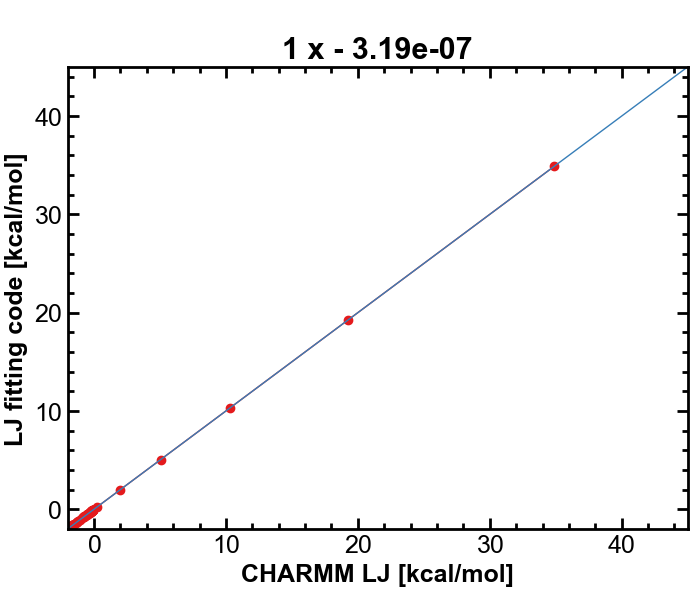

In [854]:
x = test["VDW"]
y = test["LJ"]
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
print(np.poly1d(np.polyfit(x, y, 1)))

max_val = 45

plt.scatter(test["VDW"], test["LJ"])
plt.plot([-2,max_val], [-2,max_val], )
plt.xlim(-2,max_val)
plt.ylim(-2,max_val)


plt.ylabel("LJ fitting code [kcal/mol]")
plt.xlabel("CHARMM LJ [kcal/mol]")
plt.title(np.poly1d(np.polyfit(x, y, 1)))

plt.savefig("dcm_dimer_scan_debug.pdf")


In [855]:
# ff_test.debug_df[:50]

In [856]:
# ff_test.dists["r3.1.xyz"]

In [857]:
test[["VDW", "LJ"]].describe()

,VDW,LJ
count,45.000000,45.000000
mean,1.073489,1.073488
std,6.207976,6.207974
min,-1.653810,-1.653809
25%,-0.812710,-0.812709
50%,-0.259480,-0.259476
75%,-0.094020,-0.094021
max,34.894040,34.894035


In [858]:
# test[["VDW", "LJ"]]

In [859]:
ff_test 

FF: LJ dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)

In [860]:
# df

In [902]:
ff_test.data["ELECci"] = df.loc[ff_test.data.index]["ecol"] #ff_test.data["ELEC"] 
# ff_test.data["ELECci"] = ff_test.data["ELEC"] 
ff_test.elec = "ELECci"

In [903]:
ff_test.bounds

[(0.1, 5.5), (0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (0.001, 0.1)]

In [904]:
n = 20
loss = "jax"
# ff_test.num_targets = len(targets)

ff_test.set_targets()


LJFF = fit_repeat(
        ff_test, n, f"dcm_test_fitted", bounds=ff_test.bounds, loss=loss,
        quiet=True
    )



loss:  jax
(<bound method FF.get_loss_jax of FF: LJ dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>)
loss:  jax
(<bound method FF.get_loss_jax of FF: LJ dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>)
loss:  jax
(<bound method FF.get_loss_jax of FF: LJ dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>)
loss:  jax
(<bound method FF.get_loss_jax of FF: LJ dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>)
loss:  jax
(<bound method FF.get_loss_jax of FF: LJ dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)>)


In [905]:
ff_test.targets

Array([ 2.07822323e+01,  1.45976791e+01,  1.00601053e+01,  6.78992462e+00,
        4.45132160e+00,  2.80612707e+00,  1.66649032e+00,  8.94729137e-01,
        3.77942085e-01,  2.91830788e+01, -1.56460047e-01, -2.78824091e-01,
       -3.40616226e-01, -3.71634245e-01, -3.76802564e-01, -3.68689895e-01,
       -3.35009217e-01, -3.10917675e-01,  4.76586819e-02, -2.61596143e-01,
       -2.15114117e-01, -1.92551911e-01, -1.70872718e-01, -1.51817054e-01,
       -1.35453343e-01, -1.19428337e-01, -2.86540091e-01, -8.29887092e-02,
       -7.39020109e-02, -6.58365488e-02, -5.88793159e-02, -5.26513606e-02,
       -4.71390486e-02, -4.23011035e-02, -3.82591039e-02, -3.42825949e-02,
       -9.35193002e-02, -2.83261240e-02, -2.31731385e-02, -2.09896266e-02,
       -1.74745917e-02, -1.60602629e-02, -1.32929534e-02, -3.09303552e-02,
       -1.21393055e-02], dtype=float32)

In [906]:
# ff_test.data[ff_test.elec]

In [907]:
# ff_test.data

#  Results

In [909]:
pd.DataFrame(LJFF.opt_results)#.sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
0,0.119873,1055,1638,0,True,Optimization terminated successfully.,"[1.9275441779343225, 2.1262927731902965, 0.717...","([[1.9275441779343225, 2.1262927731902965, 0.7..."
1,5.096198,62,190,0,True,Optimization terminated successfully.,"[0.10039992186227975, 0.1, 0.12462898480633877...","([[0.10039992186227975, 0.1, 0.124628984806338..."
2,0.119858,765,1193,0,True,Optimization terminated successfully.,"[1.9284539201475543, 2.1248300671559277, 0.720...","([[1.9284539201475543, 2.1248300671559277, 0.7..."
3,5.096198,94,238,0,True,Optimization terminated successfully.,"[0.1589073940309537, 0.12528323843326197, 0.10...","([[0.1589073940309537, 0.12528323843326197, 0...."
4,0.180799,833,1361,0,True,Optimization terminated successfully.,"[1.935434571120716, 1.0177360423210478, 1.6913...","([[1.935434571120716, 1.0177360423210478, 1.69..."
...,...,...,...,...,...,...,...,...
235,0.029092,579,964,0,True,Optimization terminated successfully.,"[2.1839418098110093, 2.485824856576581, 0.3990...","([[2.1839418098110093, 2.485824856576581, 0.39..."
236,0.056656,659,1114,0,True,Optimization terminated successfully.,"[0.664896888449962, 0.1, 2.120081055297123, 0....","([[0.664896888449962, 0.1, 2.120081055297123, ..."
237,0.019036,1117,1751,0,True,Optimization terminated successfully.,"[2.252783675586488, 2.3747129366096016, 0.1, 0...","([[2.252783675586488, 2.3747129366096016, 0.1,..."
238,0.158554,326,584,0,True,Optimization terminated successfully.,"[2.8148995325971122, 0.4304584557785587, 0.168...","([[2.8148995325971122, 0.4304584557785587, 0.1..."


In [868]:
set_style()

In [869]:
bulk_parms = [2.490e+00,  2.397e+00,  1.216e+00,  8.306e-03,  3.579e-02, 1.637e-02]

In [870]:
bulkjaxeval = LJFF.eval_jax(bulk_parms)[0]

In [910]:
parms = LJFF.opt_results[237]["x"]
# parms[3] *= 1.002412135
# parms[4] *= 1.002412135
# parms[5] *= 1.002412135

# parms[3] *= 1.98045
# parms[4] *= 0.98045
# parms[5] *= 1.98045

In [911]:
parms

array([2.25278368e+00, 2.37471294e+00, 1.00000000e-01, 3.78642725e-02,
       8.61077321e-02, 1.75857887e-03])

In [912]:
# deff_test.data[deff_test.elec]

In [913]:
np.mean(LJFF.targets[10:] - LJFF.eval_jax(parms)[0][10:])

Array(0.06881563, dtype=float32)

In [914]:
LJFF.eval_jax(parms)[0]

Array([20.529911  , 14.259358  ,  9.85579   ,  6.747685  ,  4.558724  ,
        3.0077453 ,  1.905303  ,  1.1343036 ,  0.5881631 , 29.501656  ,
       -0.04790678, -0.22126235, -0.3348824 , -0.40398508, -0.4429166 ,
       -0.45976293, -0.45321253, -0.43796578,  0.21203588, -0.3964039 ,
       -0.34943184, -0.32600072, -0.30338198, -0.2815887 , -0.2610106 ,
       -0.24153633, -0.4184752 , -0.19076018, -0.1761718 , -0.16272424,
       -0.15029544, -0.13889669, -0.12830897, -0.11866006, -0.10971263,
       -0.10153364, -0.20641272, -0.0870779 , -0.0748449 , -0.0694529 ,
       -0.05992772, -0.05569415, -0.04823375, -0.09402657, -0.0449394 ],      dtype=float32)

In [915]:
LJFF.targets

Array([ 2.07822323e+01,  1.45976791e+01,  1.00601053e+01,  6.78992462e+00,
        4.45132160e+00,  2.80612707e+00,  1.66649032e+00,  8.94729137e-01,
        3.77942085e-01,  2.91830788e+01, -1.56460047e-01, -2.78824091e-01,
       -3.40616226e-01, -3.71634245e-01, -3.76802564e-01, -3.68689895e-01,
       -3.35009217e-01, -3.10917675e-01,  4.76586819e-02, -2.61596143e-01,
       -2.15114117e-01, -1.92551911e-01, -1.70872718e-01, -1.51817054e-01,
       -1.35453343e-01, -1.19428337e-01, -2.86540091e-01, -8.29887092e-02,
       -7.39020109e-02, -6.58365488e-02, -5.88793159e-02, -5.26513606e-02,
       -4.71390486e-02, -4.23011035e-02, -3.82591039e-02, -3.42825949e-02,
       -9.35193002e-02, -2.83261240e-02, -2.31731385e-02, -2.09896266e-02,
       -1.74745917e-02, -1.60602629e-02, -1.32929534e-02, -3.09303552e-02,
       -1.21393055e-02], dtype=float32)

# Putting it together...

In [916]:
# print(LJFF.opt_results)
pickle_output(LJFF, f"dcm_test__fitted")
LJFF.num_segments = 45
jaxeval = LJFF.eval_jax(parms)[0]
# print(LJFF.num_segments)
# print("eval_jax::", jaxeval)
jaxloss = ff_test.get_loss_jax(LJFF.get_best_parm())
# print("jaxloss::", jaxloss)
elec = LJFF.data[LJFF.elec]
targets = LJFF.targets
# print(len(elec), len(targets), len(jaxeval))
# print("targets", targets)
residuals = targets - jaxeval
#  make the dataframe
# df_test = pd.DataFrame(
#     {
#         "target": targets,
#         "residuals": residuals,
#         "vals": jaxeval
#     }
# ).dropna()  # drop the nans
# #  plot the results
# residuals_plot(df_test, "dcm_test_targets", 
#                xlabel="$E_{int} - E_{Coloumb}$", 
#                ylabel="$E_{LJ}$")
# print(df_test.describe())
plt.clf()
#  make the dataframe
df_test = pd.DataFrame(
    {
        "target": LJFF.data[LJFF.intE],
        "elec": elec,
        "residuals": LJFF.data[LJFF.intE] - (jaxeval + elec),
        "vals": jaxeval + elec,
        "vdw": jaxeval,
        "bulk": bulkjaxeval,
        "dempol": DEMPOL,
        "ELECpc": LJFF.data["ELEC"], 
        "dempolelec": deff_test.data[deff_test.elec]
    }
).dropna()  # drop the nans
#  plot the results
# residuals_plot(df_test, "dcm_test_elec_jax",
#                xlabel="$E_{int}$", ylabel="$E_{LJ} + E_{ELEC}$")
# print(df_test.describe())
# plt.clf()
# print(ff_test.data)
# print(LJFF.data)

<Figure size 800x600 with 0 Axes>

In [917]:
LJFF

FF: LJ dcmdimerscan ELECci Exact P_intE (jax_coloumb: False)

In [918]:
# df["r"] = 

In [919]:
indexs = []
cc_dist = []
for k, v in ff_test.dists.items():
    if k in list(ff_test.data.index):
        indexs.append(k)
        cc_dist.append(v[0][0][0])

In [920]:
dist_df = pd.DataFrame({"dist": cc_dist}, index=indexs)
dist_df.sort_index(inplace=True)
# dist_df

In [921]:
dist_df["r"] = [float(_) for _ in dist_df["dist"].values]
# dist_df

In [922]:
# df

In [923]:
df["r"] = dist_df["dist"]
df["dist"] = df["KEY"].apply(lambda x: float(x[1:-4]))
df = df.sort_values("dist")
df_test["r"] = dist_df["r"]

df_test = df_test.sort_values("r")

df["tvdw"] = df["intE"] - df["ecol"]

In [924]:
mdcm = [-3.81773,
-3.43375,
-3.10108,
-2.80161,
-2.53273,
-2.29371,
-2.08245,
-1.88969,
-1.71973,
-1.56722,
-1.43028,
-1.30621,
-1.19706,
-1.09596,
-1.00731,
-0.92609,
-0.85338,
-0.78688,
-0.72807,
-0.67307,
-0.62448,
-0.57958,
-0.53916,
-0.50181,
-0.46861,
-0.43744,
-0.40900,
-0.38340,
-0.35938,
-0.33754,
-0.31733,
-0.29879,
-0.28170,
-0.26577,
-0.25114,
-0.23756,
-0.22489,
-0.21318,
-0.20232,
-0.19207,
-0.18251,
-0.17387,
-0.16536,
-0.15778,
-0.15040,
-0.14368,
-0.13727,
-0.13130,
-0.12558,
-0.12031,
-0.11527,
       ]
print(len(mdcm))

51


In [925]:
df_test

,target,elec,residuals,vals,vdw,bulk,dempol,ELECpc,dempolelec,r
r3.xyz,10.473201,-18.709878,-0.318578,10.791779,29.501656,49.936424,29.237436,-0.91863,-18.709878,3.000392
r3.1.xyz,6.238247,-14.543985,0.252322,5.985926,20.529911,31.110325,20.714272,-0.84157,-14.543985,3.100442
r3.2.xyz,3.244100,-11.353579,0.338321,2.905779,14.259358,19.735283,14.557052,-0.77328,-11.353579,3.200619
r3.3.xyz,1.143318,-8.916788,0.204316,0.939002,9.855790,12.612491,10.043626,-0.71148,-8.916788,3.300669
r3.4.xyz,-0.268664,-7.058588,0.042239,-0.310904,6.747685,8.112964,6.810012,-0.65623,-7.058588,3.400846
r3.5.xyz,-1.190637,-5.641959,-0.107402,-1.083235,4.558724,5.215638,4.487926,-0.60614,-5.641959,3.500293
r3.6.xyz,-1.754321,-4.560448,-0.201618,-1.552702,3.007745,3.333151,2.857486,-0.56134,-4.560448,3.600279
r3.7.xyz,-2.065517,-3.732007,-0.238813,-1.826704,1.905303,2.083760,1.704728,-0.52025,-3.732007,3.700520
r3.8.xyz,-2.199199,-3.093928,-0.239574,-1.959625,1.134304,1.264080,0.920022,-0.48333,-3.093928,3.799902
r3.9.xyz,-2.220741,-2.598683,-0.210221,-2.010520,0.588163,0.714066,0.386896,-0.44967,-2.598683,3.900748


2023-10-11 12:18:03 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to load font
2023-10-11 12:18:03 | DEBUG | ttFont:_readTable:459 - Reading 'maxp' table from disk
2023-10-11 12:18:03 | DEBUG | ttFont:_readTable:468 - Decompiling 'maxp' table
2023-10-11 12:18:03 | DEBUG | loggingTools:__exit__:357 - Took 0.001s to load 'maxp'
2023-10-11 12:18:03 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'maxp'
2023-10-11 12:18:03 | INFO | __init__:_prune_pre_subset:3273 - maxp pruned
2023-10-11 12:18:03 | DEBUG | ttFont:_readTable:459 - Reading 'cmap' table from disk
2023-10-11 12:18:03 | DEBUG | ttFont:_readTable:468 - Decompiling 'cmap' table
2023-10-11 12:18:03 | DEBUG | ttFont:_readTable:459 - Reading 'post' table from disk
2023-10-11 12:18:03 | DEBUG | ttFont:_readTable:468 - Decompiling 'post' table
2023-10-11 12:18:03 | DEBUG | loggingTools:__exit__:357 - Took 0.008s to load 'cmap'
2023-10-11 12:18:03 | DEBUG | loggingTools:__exit__:357 - Took 0.000s to prune 'cmap'
2023-10-

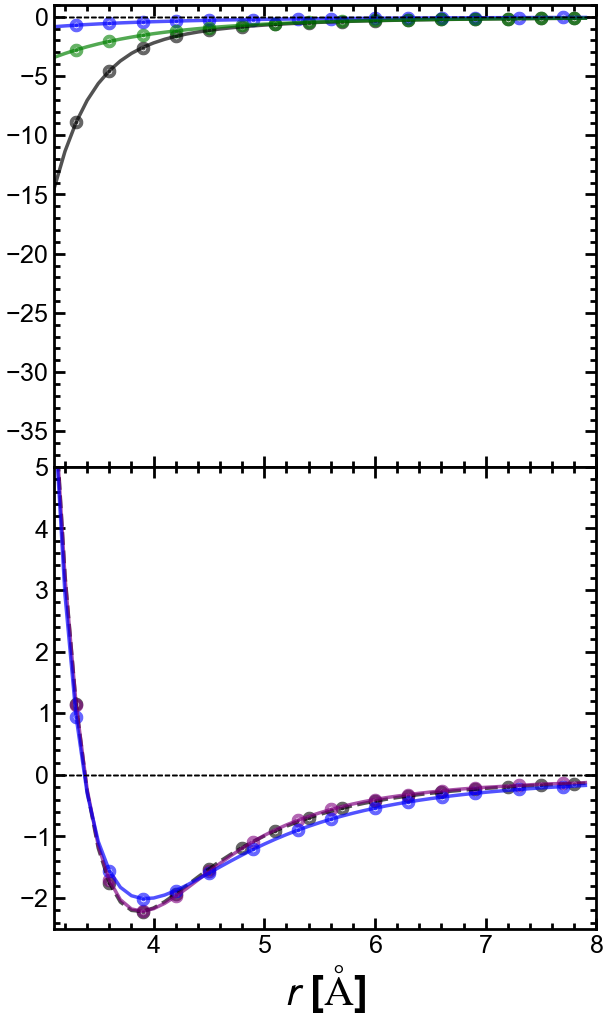

In [944]:
fig, ax = plt.subplots(2,1, figsize=(7,12), sharex=True)

def plot_scan(x, y, ax, c="k", nox=False, linestyle="-"):
    # print(type(x), [_ for _ in x.values])
    # x = [float(_) for _ in x.values]
    # print(x)
    coefs = np.polyfit(x, y, 20)
    p = np.poly1d(coefs)
    ax.scatter(x[::3], y[::3], marker="o", s=8, c=c, 
            alpha=0.6, facecolor='none', linewidth=7)
    ax.plot(np.arange(0,8,0.1), p(np.arange(0,8,0.1)), linestyle,
            c=c, alpha=0.68, linewidth=2.5)
    ax.axhline(c="k", linestyle="--")
    # ax.set_ylim(-2.5,2.5)
    ax.set_xlim(3.1,8)
    # if nox:
    #     ax.set_xlabel("")
    #     ax.set_xticklabels([])


# ax.scatter(dist_df["dist"], ff_test.data["P_intE"], c="k", s=2)
# ax.scatter(dist_df["dist"], df_test["vals"], s=2)
# ax.scatter(dist_df["dist"], df_test["elec"], s=2)
# ax.scatter(df["r"], df["ecol"], s=2)
# plt.show()
# plot_scan(df["dist"], df["pol"], ax[2], nox=True, c="red")
# plot_scan(df_test["r"], df_test["vals"], ax[0], nox=True, c="blue")
# plot_scan(df_test["r"], df_test["vdw"], ax[ljax], nox=False, c="blue")
# plot_scan(df["dist"], df["tvdw"] - df["pol"], ax[ljax], nox=False, c="k")
# plot_scan(df_test["r"], df_test["vals"], ax[0], nox=True)
# plot_scan(dist_df["dist"], df_test["vals"], ax)
# plot_scan(dist_df["dist"], df_test["vals"], ax)

elecaxs = 0
ljax = 1
deax = 1

plot_scan(df["dist"], df["intE"], ax[ljax], nox=True, c="k", linestyle="--")
# plot_scan(df["dist"], df["intE"], ax[deax], nox=True, c="k")

plot_scan(df_test["r"], df_test["dempol"] + df_test["elec"] ,
          ax[deax], nox=True, c="purple")

plot_scan(df_test["r"], df_test["vals"], ax[ljax], nox=True, c="blue")

plot_scan(df["dist"], df["ecol"], ax[elecaxs], nox=True, c="k")

# plot_scan(df["dist"], df["ecol"]+df["pol"], ax[elecaxs], nox=True, c="red")

plot_scan(df_test["r"], df_test["ELECpc"], ax[elecaxs], nox=True, c="blue")
plot_scan(df["dist"], mdcm, ax[elecaxs], nox=True, c="green")

# plot_scan(df_test["r"], 
#           df_test["bulk"] +  df_test["elec"], ax[ljax], 
#           nox=False, c="red")

plt.subplots_adjust(wspace=0, hspace=0)

# ax[ljax].set_ylabel("$E_{\mathrm{int.}}$", fontsize=30)
# ax[deax].set_ylabel("$E_{\mathrm{int.}}$", fontsize=30)
# ax[elecaxs].set_ylabel("$E_{\mathrm{Col.}}$", fontsize=30)


UP = 2.5

ax[elecaxs].set_ylim(-38,1)
ax[ljax].set_ylim(-2.5,5)
ax[deax].set_ylim(-2.5,5)

ax[deax].set_xlabel("$r$ [$\mathrm{\AA}$]", fontsize=30)

plt.savefig("dcm_scan.pdf")


In [927]:
files = [ogr[float(int(_))] for _ in list(ff_test.out_groups)]
last = [files[0]]
for _ in files:
    if _ != last[-1]:
        last.append( _)
        # print(_)

NameError: name 'ogr' is not defined

In [332]:
ff_test.data["T"].index
# targets

Index(['r3.1.xyz', 'r3.2.xyz', 'r3.3.xyz', 'r3.4.xyz', 'r3.5.xyz', 'r3.6.xyz',
       'r3.7.xyz', 'r3.8.xyz', 'r3.9.xyz', 'r3.xyz', 'r4.1.xyz', 'r4.2.xyz',
       'r4.3.xyz', 'r4.4.xyz', 'r4.5.xyz', 'r4.6.xyz', 'r4.8.xyz', 'r4.9.xyz',
       'r4.xyz', 'r5.1.xyz', 'r5.3.xyz', 'r5.4.xyz', 'r5.5.xyz', 'r5.6.xyz',
       'r5.7.xyz', 'r5.8.xyz', 'r5.xyz', 'r6.1.xyz', 'r6.2.xyz', 'r6.3.xyz',
       'r6.4.xyz', 'r6.5.xyz', 'r6.6.xyz', 'r6.7.xyz', 'r6.8.xyz', 'r6.9.xyz',
       'r6.xyz', 'r7.1.xyz', 'r7.3.xyz', 'r7.4.xyz', 'r7.6.xyz', 'r7.7.xyz',
       'r7.9.xyz', 'r7.xyz', 'r8.xyz'],
      dtype='object')

In [333]:
# df_test

In [327]:
len(df_test)

45

In [339]:
len(df.dropna())
df.loc[ff_test.data["T"].index]["ecol"]

r3.1.xyz   -14.543985
r3.2.xyz   -11.353579
r3.3.xyz    -8.916788
r3.4.xyz    -7.058588
r3.5.xyz    -5.641959
r3.6.xyz    -4.560448
r3.7.xyz    -3.732007
r3.8.xyz    -3.093928
r3.9.xyz    -2.598683
r3.xyz     -18.709878
r4.1.xyz    -1.902819
r4.2.xyz    -1.655733
r4.3.xyz    -1.454655
r4.4.xyz    -1.288800
r4.5.xyz    -1.150212
r4.6.xyz    -1.033007
r4.8.xyz    -0.846310
r4.9.xyz    -0.771030
r4.xyz      -2.210538
r5.1.xyz    -0.646842
r5.3.xyz    -0.549275
r5.4.xyz    -0.508165
r5.5.xyz    -0.471261
r5.6.xyz    -0.438020
r5.7.xyz    -0.407987
r5.8.xyz    -0.380771
r5.xyz      -0.705042
r6.1.xyz    -0.312926
r6.2.xyz    -0.294083
r6.3.xyz    -0.276791
r6.4.xyz    -0.260888
r6.5.xyz    -0.246233
r6.6.xyz    -0.232701
r6.7.xyz    -0.220182
r6.8.xyz    -0.208581
r6.9.xyz    -0.197811
r6.xyz      -0.333507
r7.1.xyz    -0.178473
r7.3.xyz    -0.161657
r7.4.xyz    -0.154064
r7.6.xyz    -0.140291
r7.7.xyz    -0.134038
r7.9.xyz    -0.122636
r7.xyz      -0.187797
r8.xyz      -0.117433
Name: ecol

In [102]:
fitted_ = {_.stem: pd.read_pickle(_) for _ in list(PKL_PATH.glob("*ELECm_dcm_lj_fitted*"))}
fitted_.keys()

fitkeys = list(fitted_.keys())
fitkeys = [
  #   'ELECnull_water_cluster_lj_fitted',
  # 'ELECci_water_cluster_lj_fitted',
  # 'ELECpol_water_cluster_lj_fitted',
  # 'ELECk_water_cluster_lj_fitted',
  # 'ELECm_water_cluster_lj_fitted',
  # 'ELECp_water_cluster_lj_fitted',
  # 'ELECnull_dcm_lj_fitted',
  # 'ELECci_dcm_lj_fitted',
  # 'ELECpol_dcm_lj_fitted',
  # 'ELECm_dcm_lj_fitted',
  # 'ELECp_dcm_lj_fitted'
]

In [118]:
debug_sum = ff.debug_df.groupby("gname").sum()

In [ ]:
ff = fitted_["ELECm_dcm_lj_fitted"]

In [120]:
ff.jax_init(LJFF.p)

2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming jit(convert_element_type) in 0.0001823902130126953 sec
2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming <lambda> for pjit in 0.0005002021789550781 sec
2023-09-11 15:10:50 | DEBUG | pxla:_cached_lowering_to_hlo:1879 - Compiling <lambda> for with global shapes and types [ShapedArray(float32[200]), ShapedArray(float32[200])]. Argument mapping: (GSPMDSharding({replicated}), GSPMDSharding({replicated})).
2023-09-11 15:10:50 | DEBUG | xla_bridge:get_compile_options:128 - get_compile_options: num_replicas=1 num_partitions=1 device_assignment=[[CpuDevice(id=0)]]
2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished XLA compilation of jit(<lambda>) in 0.007615089416503906 sec
2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming jit(copy) in 0.00023937225341796875 sec
2023-09-11 15:10:50 | DEBU

targets:
[-6.8550601e+00 -6.8375211e+00 -1.0320949e+01 -3.0146837e+00
 -3.5869360e+00 -2.0234489e+00 -8.2330475e+00 -2.7043076e+00
 -3.1953859e+00 -1.0066981e+01 -5.2109022e+00 -5.9050674e+00
 -5.8097200e+00 -5.5400987e+00 -8.3136587e+00 -9.7961292e+00
 -5.4511900e+00 -4.7509985e+00 -9.0197277e-01 -5.0976882e+00
 -6.2584181e+00 -2.5203915e+00 -9.2267179e-01 -5.0215182e+00
 -2.3995566e+00 -7.3705206e+00 -8.0960331e+00 -8.0855474e+00
 -8.2293949e+00 -3.4293680e+00 -4.8796253e+00 -5.5910783e+00
 -7.6319351e+00 -5.9212208e+00 -6.2004533e+00 -5.4448833e+00
 -9.6716223e+00 -2.7415481e+00 -5.1012983e+00 -3.3970027e+00
 -4.1764102e+00 -5.4643755e+00 -1.1230443e+01 -7.0369716e+00
 -6.2448788e+00 -8.2465210e+00 -7.7768040e+00 -5.4082432e+00
 -1.3218880e-01  1.4789262e+00 -3.3929038e+00 -8.8888149e+00
 -6.8272839e+00 -4.4609404e+00 -6.0446835e+00 -4.6254110e+00
 -1.5102091e+00 -8.6423302e+00 -6.8167067e+00 -3.7720907e+00
 -8.6685524e+00  3.1472297e+00 -1.1224448e+01 -1.0681319e+01
 -9.7626724e+00

2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming jit(convert_element_type) in 0.00022101402282714844 sec


debug
groups
342000
200
dists
342000


2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming jit(convert_element_type) in 0.00036716461181640625 sec
2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming jit(copy) in 0.00030422210693359375 sec
2023-09-11 15:10:50 | DEBUG | pxla:_cached_lowering_to_hlo:1879 - Compiling copy for with global shapes and types [ShapedArray(int32[342000])]. Argument mapping: (GSPMDSharding({replicated}),).
2023-09-11 15:10:50 | DEBUG | xla_bridge:get_compile_options:128 - get_compile_options: num_replicas=1 num_partitions=1 device_assignment=[[CpuDevice(id=0)]]
2023-09-11 15:10:50 | WARNING | dispatch:log_elapsed_time:270 - Finished XLA compilation of jit(copy) in 0.006351947784423828 sec


In [125]:
ff.num_segments = 200

In [126]:
LJFF.p

[1.91, 1.34, 2.01, -0.343, -0.024, -0.0561]

In [127]:
ff.eval_jax(LJFF.p) + ff.data[ff.elec]

indexs shape (array(342000, dtype=int32),)
dists shape (array(342000, dtype=int32),)
comb_parms shape (array(12, dtype=int32),)
comb_parms [3.82       3.25       2.68       3.92       3.35       4.02
 0.343      0.09073037 0.024      0.13871662 0.03669332 0.0561    ]
sigma_s (array(342000, dtype=int32),)
sigma [3.82 3.82 3.82 ... 4.02 4.02 4.02]
eps_s (array(342000, dtype=int32),)
eps [3.92  3.92  3.92  ... 0.024 0.024 0.024]


100_1018_DCM_120_967    -90.051086
100_1019_DCM_120_565    -98.459160
100_1024_DCM_121_932    -88.328529
100_1053_DCM_123_948   -116.927422
100_1100_DCM_129_15    -122.304626
                           ...    
100_979_DCM_115_117     -69.655296
100_983_DCM_116_25     -133.518799
100_986_DCM_116_989     -91.988159
100_98_DCM_12_534      -110.899071
100_992_DCM_117_761    -136.640030
Name: ELECm, Length: 200, dtype: float32

In [128]:
debug_sum

,es,akp,idx,distances,sigmas,epsilons
gname,,,,,,
100_1018_DCM_120_967,4.679388e+05,5320,1461195,17569.118617,7917.249714,2795.567132
100_1019_DCM_120_565,7.898120e+05,5320,4385295,17615.509527,7917.249714,2795.567132
100_1024_DCM_121_932,3.639569e+05,5320,7309395,17304.095044,7917.249714,2795.567132
100_1053_DCM_123_948,7.841421e+05,5320,10233495,16397.272239,7917.249714,2795.567132
100_1100_DCM_129_15,7.220288e+05,5320,13157595,16850.721284,7917.249714,2795.567132
...,...,...,...,...,...,...
100_979_DCM_115_117,3.569682e+05,5320,571660695,21309.277087,7917.249714,2795.567132
100_983_DCM_116_25,1.100597e+06,5320,574584795,15931.997308,7917.249714,2795.567132
100_986_DCM_116_989,5.042633e+05,5320,577508895,17248.964215,7917.249714,2795.567132


In [130]:
ff.debug_df

,group,es,akp,idx,gname,distances,sigmas,epsilons
0,0,-2.126215,0,0,100_1018_DCM_120_967,10.841139,9.843714,2.635503
1,0,39625.826790,0,1,100_1018_DCM_120_967,4.410378,9.843714,2.635503
2,0,-2.095797,0,2,100_1018_DCM_120_967,10.883423,9.843714,2.635503
3,0,566.582409,0,3,100_1018_DCM_120_967,6.220990,9.843714,2.635503
4,0,-0.998565,0,4,100_1018_DCM_120_967,12.748889,9.843714,2.635503
...,...,...,...,...,...,...,...,...
341995,199,-0.000890,5,341995,100_992_DCM_117_761,7.572867,2.023099,1.223674
341996,199,-0.000068,5,341996,100_992_DCM_117_761,11.620529,2.023099,1.223674
341997,199,-0.000068,5,341997,100_992_DCM_117_761,11.620529,2.023099,1.223674
341998,199,-0.000082,5,341998,100_992_DCM_117_761,11.272764,2.023099,1.223674


In [129]:
ff.eval_jax(LJFF.p)

indexs shape (array(342000, dtype=int32),)
dists shape (array(342000, dtype=int32),)
comb_parms shape (array(12, dtype=int32),)
comb_parms [3.82       3.25       2.68       3.92       3.35       4.02
 0.343      0.09073037 0.024      0.13871662 0.03669332 0.0561    ]
sigma_s (array(342000, dtype=int32),)
sigma [3.82 3.82 3.82 ... 4.02 4.02 4.02]
eps_s (array(342000, dtype=int32),)
eps [3.92  3.92  3.92  ... 0.024 0.024 0.024]


Array([ -84.494354,  -90.80817 ,  -84.28933 , -108.87056 , -112.5487  ,
       -141.51701 ,  -82.83136 ,  -71.1442  ,  -65.57733 ,  -75.317345,
        -66.49149 ,  -80.15694 , -102.78669 ,  192.76549 , -127.37871 ,
       -129.09282 ,  -97.692986,  -87.40814 , -122.916855, -106.955414,
       -106.350426, -101.344215,  -88.64106 ,  -65.972984,  -93.6203  ,
       -111.79648 , -135.19746 ,  -69.65386 ,  -64.373764,  -95.89479 ,
       -105.49974 ,  -52.03084 ,  -75.17563 ,  -91.02495 ,   78.44954 ,
        -43.213814, -110.8836  , -118.31719 , -111.09949 ,  -77.35783 ,
        -77.295265, -115.99766 , -101.77045 ,  -94.30604 ,  -77.80781 ,
       -114.06278 , -109.80912 ,  -27.8385  ,  -74.32244 ,  -78.99709 ,
       -110.53142 , -115.38822 ,  -79.16781 , -126.823875,  -63.5866  ,
       -124.94141 , -107.671616,  -79.9903  , -129.6764  ,  -70.27559 ,
        -21.173931, -114.57665 , -140.5779  , -125.356064,  -82.07911 ,
        -57.244225, -123.26249 ,  -77.54224 ,  -80.230064, -119.

In [153]:
# ff.intE
# ff.targets
ff.num_segments

200

In [154]:
n = 1
loss = "jax"
# ff_test.num_targets = len(targets)

ff.set_targets()


LJFF = fit_repeat(
        ff, n, f"dcmff_test_fitted", bounds=ff_test.bounds, loss=loss,
        quiet=False
    )

targets:
[-6.8550601e+00 -6.8375211e+00 -1.0320949e+01 -3.0146837e+00
 -3.5869360e+00 -2.0234489e+00 -8.2330475e+00 -2.7043076e+00
 -3.1953859e+00 -1.0066981e+01 -5.2109022e+00 -5.9050674e+00
 -5.8097200e+00 -5.5400987e+00 -8.3136587e+00 -9.7961292e+00
 -5.4511900e+00 -4.7509985e+00 -9.0197277e-01 -5.0976882e+00
 -6.2584181e+00 -2.5203915e+00 -9.2267179e-01 -5.0215182e+00
 -2.3995566e+00 -7.3705206e+00 -8.0960331e+00 -8.0855474e+00
 -8.2293949e+00 -3.4293680e+00 -4.8796253e+00 -5.5910783e+00
 -7.6319351e+00 -5.9212208e+00 -6.2004533e+00 -5.4448833e+00
 -9.6716223e+00 -2.7415481e+00 -5.1012983e+00 -3.3970027e+00
 -4.1764102e+00 -5.4643755e+00 -1.1230443e+01 -7.0369716e+00
 -6.2448788e+00 -8.2465210e+00 -7.7768040e+00 -5.4082432e+00
 -1.3218880e-01  1.4789262e+00 -3.3929038e+00 -8.8888149e+00
 -6.8272839e+00 -4.4609404e+00 -6.0446835e+00 -4.6254110e+00
 -1.5102091e+00 -8.6423302e+00 -6.8167067e+00 -3.7720907e+00
 -8.6685524e+00  3.1472297e+00 -1.1224448e+01 -1.0681319e+01
 -9.7626724e+00

In [156]:
ff.atom_type_pairs

[('C', 'C'), ('C', 'CL'), ('C', 'H'), ('CL', 'CL'), ('CL', 'H'), ('H', 'H')]

In [159]:
print(LJFF.opt_results)
pickle_output(LJFF, f"dcm_test__fitted")
LJFF.num_segments = 200
jaxeval = LJFF.eval_jax(LJFF.get_best_parm(), )

print(LJFF.num_segments)


print("eval_jax::", jaxeval)
jaxloss = ff.get_loss_jax(LJFF.get_best_parm())

print("jaxloss::", jaxloss)


elec = LJFF.data[LJFF.elec]

targets = LJFF.targets

print(len(elec), len(targets), len(jaxeval))



print("targets", targets)
residuals = targets - jaxeval
#  make the dataframe
df_test = pd.DataFrame(
    {
        "target": targets,
        "residuals": residuals,
        "vals": jaxeval
    }
).dropna()  # drop the nans
#  plot the results
residuals_plot(df_test, "dcm_test_targets")
print(df_test.describe())
plt.clf()


#  make the dataframe
df_test = pd.DataFrame(
    {
        "target": LJFF.data[LJFF.intE],
        "residuals": LJFF.data[LJFF.intE] - (jaxeval + elec),
        "vals": jaxeval + elec
    }
).dropna()  # drop the nans
#  plot the results
residuals_plot(df_test, "dcm_test_elec_jax")
print(df_test.describe())

plt.clf()
print(ff_test.data)
print(LJFF.data)

[       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 12.533696174621582
             x: [ 1.454e+00  1.933e-03  1.003e-03  3.193e+00  5.488e+00
                  5.500e+00]
           nit: 246
          nfev: 472
 final_simplex: (array([[ 1.454e+00,  1.933e-03, ...,  5.488e+00,
                         5.500e+00],
                       [ 1.454e+00,  1.933e-03, ...,  5.488e+00,
                         5.500e+00],
                       ...,
                       [ 1.454e+00,  1.933e-03, ...,  5.488e+00,
                         5.500e+00],
                       [ 1.454e+00,  1.933e-03, ...,  5.488e+00,
                         5.500e+00]]), array([ 1.253e+01,  1.253e+01,  1.253e+01,  1.253e+01,
                        1.253e+01,  1.253e+01,  1.253e+01])),        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 12.06592082977295
             x: [ 1.485e+00  2.297e+00  1.073e-

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:01 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved


indexs shape (array(342000, dtype=int32),)
dists shape (array(342000, dtype=int32),)
comb_parms shape (array(12, dtype=int32),)
comb_parms [0.34518853 1.8446044  3.3440201  0.24771068 1.7471265  0.15023282
 4.5541415  2.3759565  1.2395684  1.9183946  1.0008521  0.80810785]
sigma_s (array(342000, dtype=int32),)
sigma [0.34518853 0.34518853 0.34518853 ... 0.15023282 0.15023282 0.15023282]
eps_s (array(342000, dtype=int32),)
eps [0.24771068 0.24771068 0.24771068 ... 1.2395684  1.2395684  1.2395684 ]
200
eval_jax:: [-4.440532  -4.9451904 -4.548495  -5.4934144 -5.672168  -7.1174836
 -4.2040596 -3.633995  -3.3919969 -3.771903  -3.3830662 -4.011844
 -5.731735  -4.835928  -6.131169  -6.593844  -4.877544  -4.35206
 -5.719584  -5.403006  -5.426664  -5.1045575 -4.4338665 -3.454035
 -5.2869415 -5.9499187 -7.2437162 -3.6514122 -3.3522832 -4.837257
 -5.256603  -2.7224164 -4.886544  -6.0802174 -3.4623249 -4.7938504
 -5.7396274 -5.251166  -5.754101  -4.949257  -4.056678  -5.93882
 -5.3672433 -5.094972

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:01 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:01 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:01 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:01 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:01 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:to

saving  dcm_test_targets


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:03 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
2023-09-11 15:24:03 | DEBUG | _base:_update_title_position:2966 - title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
2023-09-11 15:24:03 | DEBUG | _base:_update_title_position:2966 - title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:03 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:03 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._bas

           target   residuals        vals
count  200.000000  200.000000  200.000000
mean    -5.235604   -0.361085   -4.874519
std      3.173642    3.442436    1.326724
min    -12.734488   -7.627217   -8.481735
25%     -7.720223   -2.899379   -5.780948
50%     -5.456869   -0.825863   -4.882044
75%     -3.264148    2.149330   -3.975113
max      4.455761   11.298174   -0.831434


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:06 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:06 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:06 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:06 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:06 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:to

saving  dcm_test_elec_jax


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:08 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
2023-09-11 15:24:08 | DEBUG | _base:_update_title_position:2966 - title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
2023-09-11 15:24:08 | DEBUG | _base:_update_title_position:2966 - title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:08 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-11 15:24:08 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._bas

           target   residuals        vals
count  200.000000  200.000000  200.000000
mean   -12.902028   -0.361085  -12.540943
std      4.166206    3.442436    3.743724
min    -24.250399   -7.627215  -21.247763
25%    -15.957837   -2.899378  -15.328609
50%    -12.779601   -0.825863  -12.573431
75%    -10.030667    2.149329   -9.709576
max     -2.586429   11.298173   -4.026644
             TOTAL     ELEC       VDW       KEY     M_ENERGY  n_monomers  \
r3.1.xyz  19.15613 -0.84157  19.22300  r3.1.xyz -1918.743238         2.0   
r3.2.xyz  11.19794 -0.77328  10.28236  r3.2.xyz -1918.743238         2.0   
r3.3.xyz   7.22620 -0.71148   5.04008  r3.3.xyz -1918.743238         2.0   
r3.4.xyz   5.51765 -0.65623   1.99860  r3.4.xyz -1918.743238         2.0   
r3.5.xyz   5.01956 -0.60614   0.23506  r3.5.xyz -1918.743238         2.0   
r3.6.xyz   4.87844 -0.56134  -0.75695  r3.6.xyz -1918.743238         2.0   
r3.7.xyz   4.94221 -0.52025  -1.29823  r3.7.xyz -1918.743238         2.0   
r3.8.xyz   4.9

In [162]:
res = ff.eval_dist(ff.p)

['H', 'C', 'CL'] [1.91, 1.34, 2.01, -0.343, -0.024, -0.0561]
0 H
1 C
2 CL
self.p [1.91, 1.34, 2.01, -0.343, -0.024, -0.0561]
sig [2.68, 3.3499999999999996, 3.25, 4.02, 3.92, 3.82]
ep [0.024, 0.036693323643409576, 0.09073036977771005, 0.0561, 0.13871661760582255, 0.343]
epsilons {'H': -0.343, 'C': -0.024, 'CL': -0.0561}
rminhalfs {'H': 1.91, 'C': 1.34, 'CL': 2.01}
ATP:: [('C', 'C'), ('C', 'CL'), ('C', 'H'), ('CL', 'CL'), ('CL', 'H'), ('H', 'H')]
debug
groups
342000
200
dists
342000


In [165]:
ff.debug_df

,group,es,akp,idx,gname,distances,sigmas,epsilons
0,0,-2.126215,0,0,100_1018_DCM_120_967,10.841139,9.843714,2.635503
1,0,39625.826790,0,1,100_1018_DCM_120_967,4.410378,9.843714,2.635503
2,0,-2.095797,0,2,100_1018_DCM_120_967,10.883423,9.843714,2.635503
3,0,566.582409,0,3,100_1018_DCM_120_967,6.220990,9.843714,2.635503
4,0,-0.998565,0,4,100_1018_DCM_120_967,12.748889,9.843714,2.635503
...,...,...,...,...,...,...,...,...
341995,199,-0.000890,5,341995,100_992_DCM_117_761,7.572867,2.023099,1.223674
341996,199,-0.000068,5,341996,100_992_DCM_117_761,11.620529,2.023099,1.223674
341997,199,-0.000068,5,341997,100_992_DCM_117_761,11.620529,2.023099,1.223674
341998,199,-0.000082,5,341998,100_992_DCM_117_761,11.272764,2.023099,1.223674


In [164]:
res[0]

[10.841139100666497,
 4.4103775348602525,
 10.883422899069943,
 6.2209898730025275,
 12.74888897120059,
 5.286323959047534,
 8.704140164312612,
 9.388392034848138,
 8.521421301637423,
 6.463368935779544,
 10.34513900341605,
 6.597982722014358,
 15.910325075245948,
 9.352410331032317,
 4.169237939959771,
 6.038370806765678,
 9.260838298987842,
 6.036079025327617,
 11.218888625884473,
 10.708601822833828,
 10.744328224696043,
 7.3792388496375425,
 10.756811562912127,
 12.716756504706694,
 14.799711922872012,
 13.86749566432238,
 5.03164605273463,
 9.954615964465932,
 9.863778079417642,
 4.888298783830628,
 10.090984144274529,
 12.904553692398665,
 13.855379388526321,
 10.313931306732657,
 7.835405350076024,
 11.88978204173651,
 5.361472652173094,
 14.234652085667568,
 5.243838002837235,
 15.925288254848013,
 4.205223061860095,
 11.046296845549643,
 13.616275004567145,
 7.056126061799066,
 6.252006238000726,
 13.355935496999079,
 8.123131785216833,
 18.0574680949462,
 8.888233176509265,
 

In [186]:
LJFF.debug_df

AttributeError: 'FF' object has no attribute 'debug_df'